# Heart Failure Prediction

## Introduction

According to the World Health Organization (WHO), cardiovascular diseases (CVDs) are the number one cause of death globally, with an estimated 17.9 million people died from CVDs in 2016, representing 31% of all global deaths.<br>
In this notebook, we aim to use machine learning to predict heart failure of CVDs patients based on their medical records. To do so we will start by exploring our dataset then applying different classification algorithms and compare their results to choose the most accurate.<br>

#### Libraries

In [1]:
#Data manipulation
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100) 

import numpy as np

#Statistics
from scipy.stats import iqr,probplot

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

#Preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler

#Classification Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

## Data

The data used in this study is the Kaggle dataset 'Heart Failure Prediction' [[0]](#ref0), it was taken from the scientific article *'Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone.'* published in BMC Medical Informatics and Decision Making.[[1]](#ref1).<br>
This dataset represents the medical records of 299 heart failure patients during April–December 2015 , all the patients are suffering from Left ventricular systolic dysfunction (LVSD) which is a complication that increases the risks of sudden death and heart failure and all the observed patients had previous heart failures.<br>
We will start by reading the csv file containing the dataset and visualising the first 5 rows.

In [2]:
clinicalData = pd.read_csv('./Data/heart_failure_clinical_records_dataset.csv')
print('The heart clinical data dataset shape : ',clinicalData.shape)
clinicalData.head()

The heart clinical data dataset shape :  (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Data Analysis

The dataset contains 13 columns: 7 numerical features, 5 boolean features, and a target variable.<br>
- **Numerical Features :** age, creatinine_phosphokinase, ejection_fraction, platelets, serum_creatinine, serum_sodium, time
- **Categorical Boolean Features:** anemia, diabetes, high_blood_pressure, sex, smoking

The column DEATH_EVENT is our target column. It is a boolean variable where the values correspond to :<br>
- **1:** Patient has died before the end of the follow-up period.<br>
- **0:** Patient has survived the follow-up period.<br>

Let's check the proportion of the death events in our data set.

0    67.892977
1    32.107023
Name: DEATH_EVENT, dtype: float64


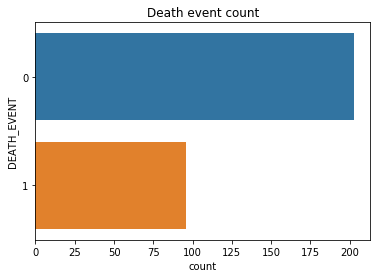

In [3]:
print(clinicalData['DEATH_EVENT'].value_counts(normalize=True) * 100)
sns.countplot(data=clinicalData,y='DEATH_EVENT')
plt.title('Death event count')
plt.show()

In our dataset, 32.11% (approximately the third) of the cases have died before the end of the follow-up period.

### Univariate Analysis

In this section we will explore and analyse each column seperatly.

In [4]:
numerical_columns = ['age','creatinine_phosphokinase','ejection_fraction',
                     'platelets','serum_creatinine','serum_sodium','time']

categorical_columns =['anaemia','diabetes','high_blood_pressure','sex','smoking']

#### Numerical Features: 

First, we compute the statistic descriptive table: 

In [5]:
clinicalData[numerical_columns].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000


Let's check the different quantiles of our numerical features:

In [6]:
clinicalData[numerical_columns].quantile([0.05,0.1, 0.25,0.3 ,0.5, 0.75, 0.95])

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0.05,42.9,59.0,20.0,131800.0,0.7,130.0,12.9
0.10,45.0,67.6,25.0,153000.0,0.8,132.0,26.8
0.25,51.0,116.5,30.0,212500.0,0.9,134.0,73.0
0.30,53.0,130.4,30.0,221000.0,1.0,135.0,79.4
0.50,60.0,250.0,38.0,262000.0,1.1,137.0,115.0
0.75,70.0,582.0,45.0,303500.0,1.4,140.0,203.0
0.95,82.0,2263.0,60.0,422500.0,3.0,144.0,250.0


We compute the IQR of each feature:

In [7]:
iqr(clinicalData[numerical_columns], axis=0)

array([1.900e+01, 4.655e+02, 1.500e+01, 9.100e+04, 5.000e-01, 6.000e+00,
       1.300e+02])

We explore the feature's distributions:

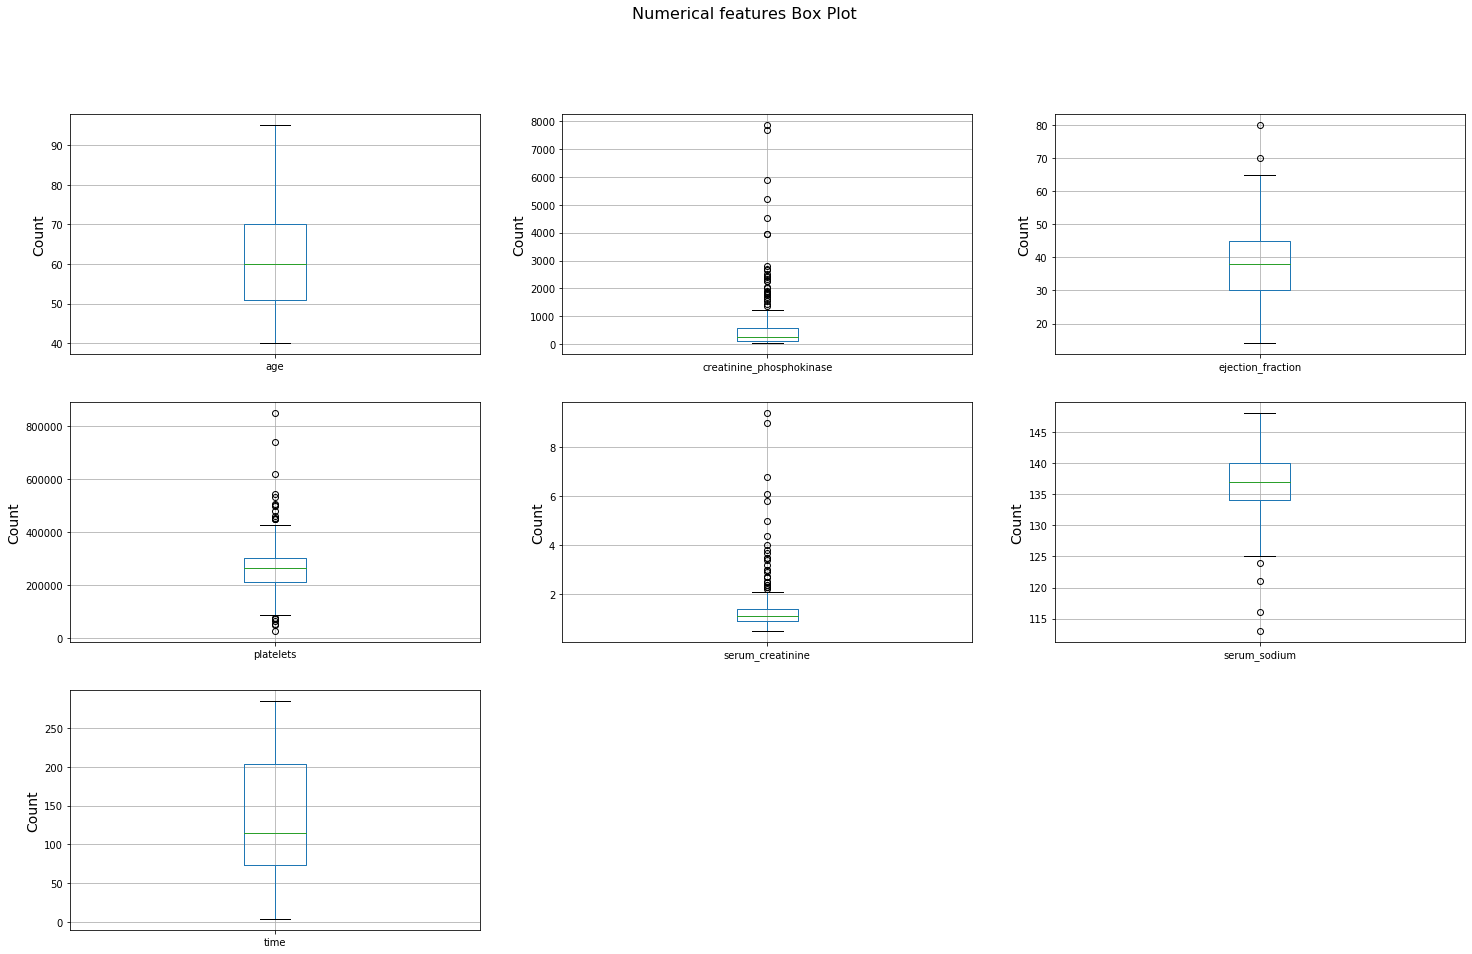

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
for i, column in enumerate(numerical_columns):
    i0=i//3
    i1=i%3 
    clinicalData.boxplot(column=[column],ax=axes[i0][i1])
    #axes[i0][i1].set_xlabel(column, size=14)
    axes[i0][i1].set_ylabel("Count", size=14)
    #axes[i0][i1].legend(loc='upper right')

fig.delaxes(axes[2,1])    
fig.delaxes(axes[2,2])  
fig.suptitle('Numerical features Box Plot', fontsize=16)
plt.show()

**Age:** The Age boxplot shows no outlier, the ages of our population ranges from 40 to 95 years old and 75% of the observations lie under 70 years.<br>
**Creatinine phosphokinase:** or  CPK is an enzyme found mainly in the heart, brain, and skeletal muscle. The normal values of CPK are 10 to 120 micrograms per liter (mcg/L)[[2]](#ref2). The box plot shows approximately only 25% of the population have a normal CPK enzyme level in the blood. High levels of CPK indicate that the patient has an injury in a muscle tissue such as the heart, or the brain. The outliers may be an indication of heart failure .<br>
**Ejection fraction:** It is a measurement in percentage of how much blood the left ventricle pumps out with each contraction. A normal EF is between 50 and 70%. Having less than 40% may indicate heart failure, a range of 41-49% can indicate damage that may be due to an old heart attack[[3]](#ref3).
In our case, the normal range is outside the IQR. We can see that 75% of our population has approximately an EF of 45% or less, which is cohesive with our prior knowledge of the dataset since all the patients had suffered from previous heart failures.<br>
**Platelets:** The platelets are blood cells that initiate clots to stop bleedings. The normal count is 150000 to 450000 platelets per microliter of blood[[4]](#ref4). The boxplot shows outliers in both ends with an IQR lying in the normal range. We can see from the graph that patients having platelets higher than the norm are all in the outlier's region.<br>
**Serum creatinine:** The serum creatinine is a waste product generated by creatine when a muscle breaks down. The boxplot of the serum creatinine is very similar to the CPK's boxplot, which may indicate a high correlation between the two.<br>
**Serum sodium:** Sodium is a mineral present in the human body. It is important for nerve and muscle function. The normal results of Sodium in the blood are 135 to 145 mEq/L (milliequivalents per liter). Having a low sodium level is called hyponatremia. A condition that may damage the cells causing them to swell and retain water. Hyponatremia can be due to several causes and pathologies among them heart failure[[6]](#ref6).In our observed population, 30% of the patients have 135 mEq/L or less. we can also see 4 outliers in the boxplot with a sodium level lower than 125 mEq/L, this hyponatremia cases may be due to previous heart failures.<br> 
**Time:** It represents the follow-up period, which goes from 4 to 285 days and on average is equal to 130 days.<br>

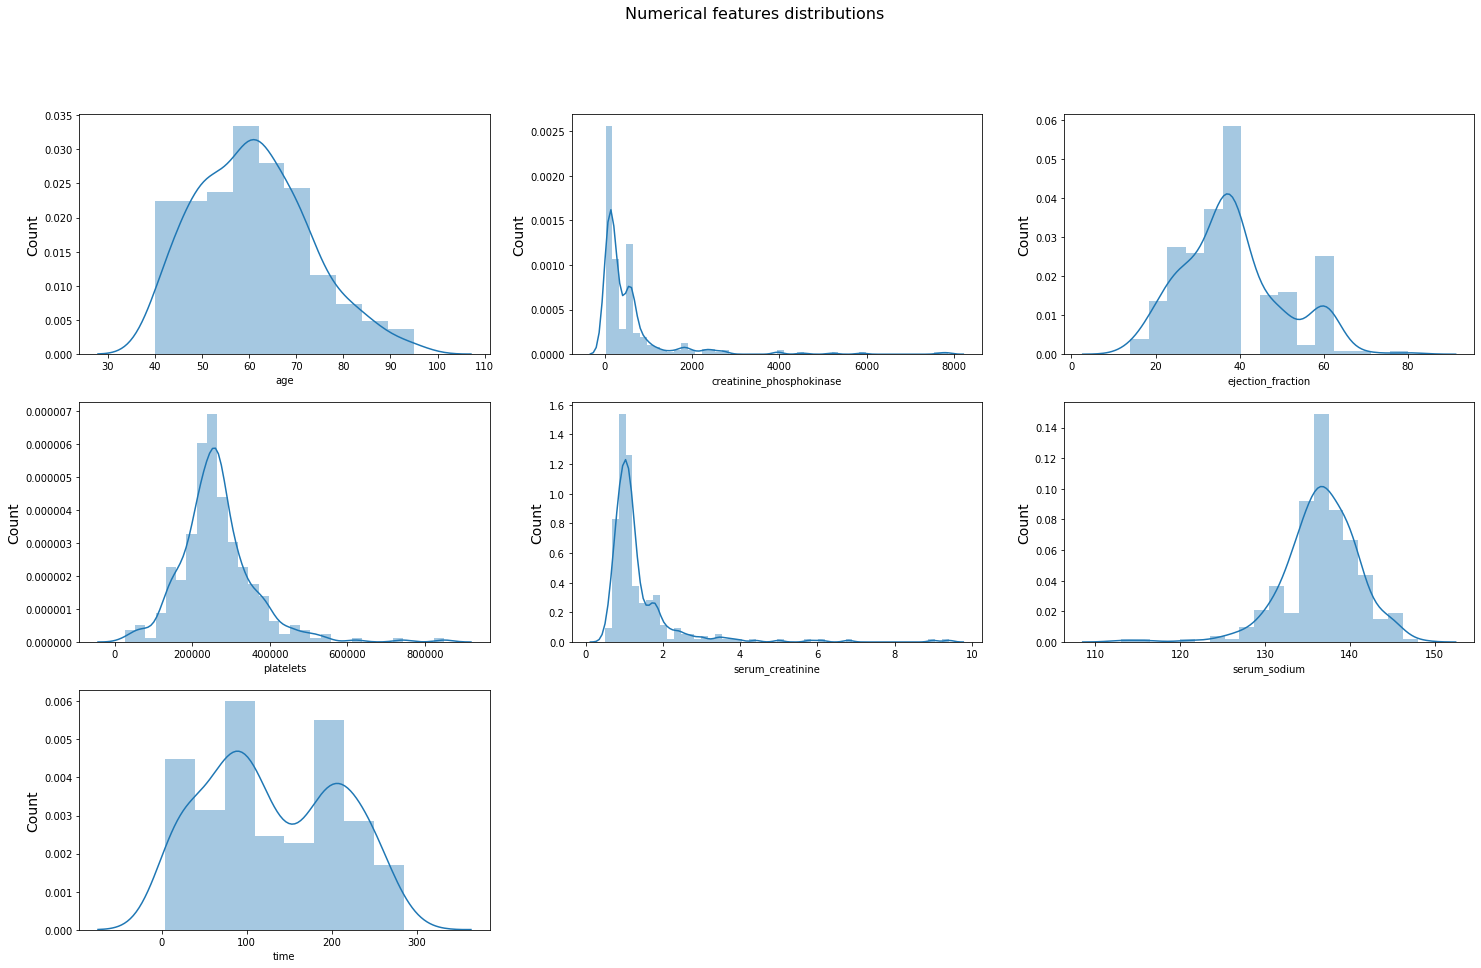

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
for i, column in enumerate(numerical_columns):
    i0=i//3
    i1=i%3 
    sns.distplot(clinicalData[column],ax=axes[i0][i1])
    #axes[i0][i1].set_xlabel(column, size=14)
    axes[i0][i1].set_ylabel("Count", size=14)
    #axes[i0][i1].legend(loc='upper right')

fig.delaxes(axes[2,1])    
fig.delaxes(axes[2,2])  
fig.suptitle('Numerical features distributions', fontsize=16)
plt.show()

In [10]:
clinicalData[numerical_columns].mode()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,60.0,582.0,35.0,263358.03,1.0,136.0,187
1,NaN,NaN,NaN,NaN,NaN,NaN,250


In [11]:
clinicalData[numerical_columns].median()

age                             60.0
creatinine_phosphokinase       250.0
ejection_fraction               38.0
platelets                   262000.0
serum_creatinine                 1.1
serum_sodium                   137.0
time                           115.0
dtype: float64

In [12]:
clinicalData[numerical_columns].mean()

age                             60.833893
creatinine_phosphokinase       581.839465
ejection_fraction               38.083612
platelets                   263358.029264
serum_creatinine                 1.393880
serum_sodium                   136.625418
time                           130.260870
dtype: float64

**Age:** It is a normal distribution with a mode of 60 years old, equal to the median found in the boxplot.<br>
**Creatinine phosphokinase:** As seen in the density plot, It is a right-skewed distribution with a mode equal to 582.0 mcg/L and a positively skewed tail.<br>
**Ejection fraction:** It is a right-skewed distribution with a mode of 35% .<br>
**Platelets:** It is a distribution slightly skewed to the right. We can verify the positive skewness if the mean is higher than the median. We have a mean equal to 263358.029264 platelets per microliter of blood, and a median equal to 262000.0 platelets per microliter of blood. Which confirms the positive skewness.<br>
**Serum creatinine:** The shape of the distribution is very similar to the Creatinine phosphokinase graph which strengthens our hypothesis of a strong correlation between the two. We might consider only one feature in our final model.<br>
**Serum sodium:** It is a left-skewed distribution with a mode of 136.0 mEq/L.<br>
**Time:** It is a bimodal distribution, the first mode is equal to 187 days and the second to 250 days of follow-up.<br>

#### Categorical Features: 

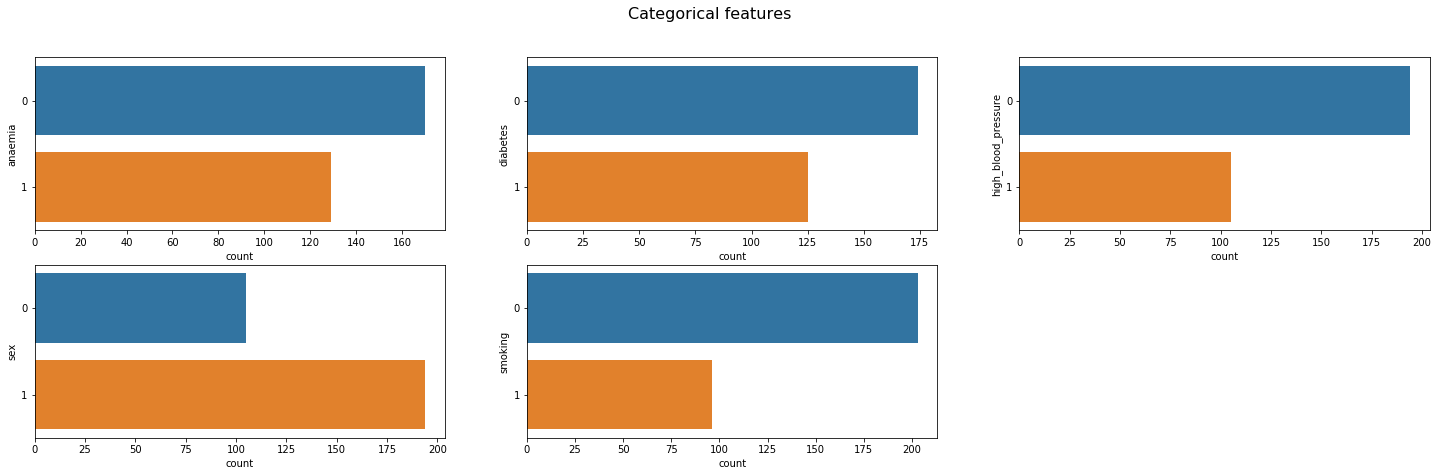

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 7))

for i,column in enumerate(categorical_columns):
    i0=i//3
    i1=i%3
    sns.countplot(data=clinicalData,y=column,ax=axes[i0,i1])

fig.delaxes(axes[1,2])
fig.suptitle('Categorical features', fontsize=16)
plt.show()

**Anaemia:** Represents whether the patient suffers from anemia or not. In our dataset, the majority of patients approximately 170 patient doesn't have anemia.<br>
**Diabetes:**  According to the graph the majority of our observed cases, 174 patients don't suffer from diabetes .<br>
**High Blood Pressure:**The graph shows that 194 patients, approximately the third of the population, don't have high blood pressure.<br>
**Sex:** The population consists of 105 women and 194 men.<br>
**Smoking:** The majority of our population doesn't smoke, as we have 203 nonsmokers and 96 smokers.<br>

### Bivariate Analysis

In this section, we will try to explore the relation of each feature to the death event.

In [14]:
clinicalData_0 = clinicalData[clinicalData['DEATH_EVENT'] == 0].iloc[:,:-1]
clinicalData_1 = clinicalData[clinicalData['DEATH_EVENT'] == 1].iloc[:,:-1]

#### Numerical Features: 

In [15]:
clinicalData_0[numerical_columns].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,58.761906,540.054187,40.266010,266657.489901,1.184877,137.216749,158.339901
std,10.637890,753.799572,10.859963,97531.202283,0.654083,3.982923,67.742872
min,40.000000,30.000000,17.000000,25100.000000,0.500000,113.000000,12.000000
25%,50.000000,109.000000,35.000000,219500.000000,0.900000,135.500000,95.000000
50%,60.000000,245.000000,38.000000,263000.000000,1.000000,137.000000,172.000000
75%,65.000000,582.000000,45.000000,302000.000000,1.200000,140.000000,213.000000
max,90.000000,5209.000000,80.000000,850000.000000,6.100000,148.000000,285.000000


In [16]:
clinicalData_1[numerical_columns].describe()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,65.215281,670.197917,33.468750,256381.044792,1.835833,135.375000,70.885417
std,13.214556,1316.580640,12.525303,98525.682856,1.468562,5.001579,62.378281
min,42.000000,23.000000,14.000000,47000.000000,0.600000,116.000000,4.000000
25%,55.000000,128.750000,25.000000,197500.000000,1.075000,133.000000,25.500000
50%,65.000000,259.000000,30.000000,258500.000000,1.300000,135.500000,44.500000
75%,75.000000,582.000000,38.000000,311000.000000,1.900000,138.250000,102.250000
max,95.000000,7861.000000,70.000000,621000.000000,9.400000,146.000000,241.000000


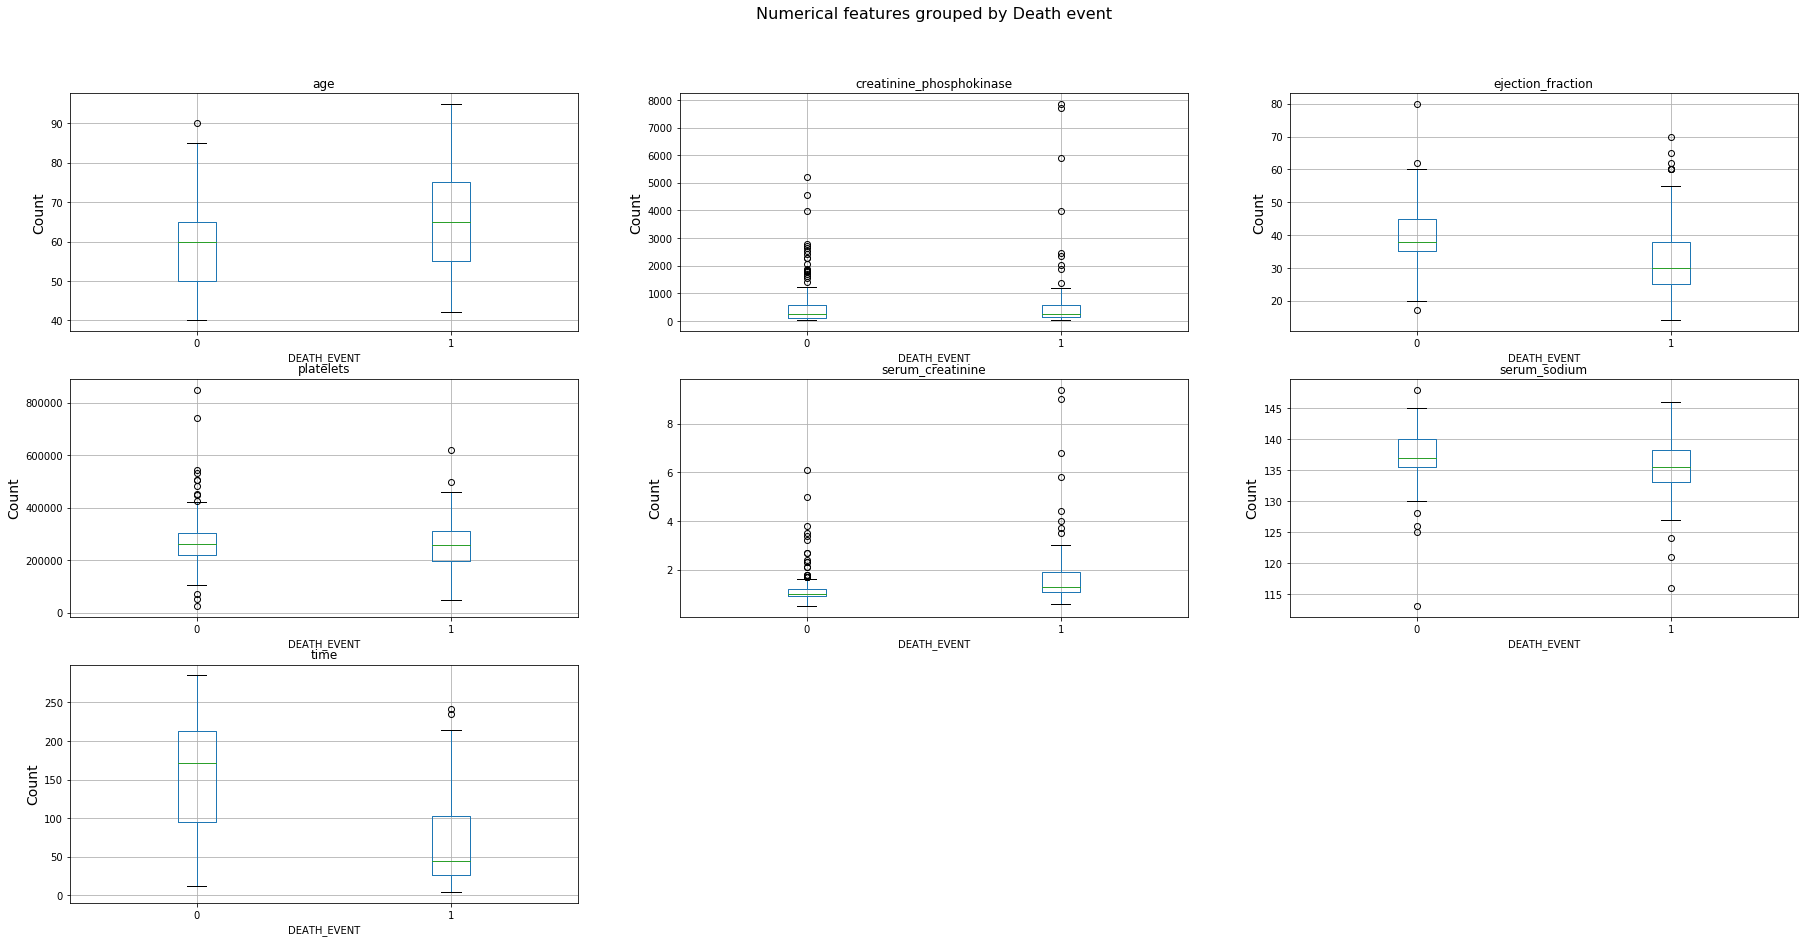

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
numerical_columns = ['age','creatinine_phosphokinase','ejection_fraction',
                     'platelets','serum_creatinine','serum_sodium','time']
for i, column in enumerate(numerical_columns):
    i0=i//3
    i1=i%3 
    clinicalData.boxplot(column=[column],by='DEATH_EVENT',ax=axes[i0][i1])
    axes[i0][i1].set_ylabel("Count", size=14)

fig.delaxes(axes[2,1])    
fig.delaxes(axes[2,2])  
fig.suptitle('Numerical features grouped by Death event', fontsize=16)
plt.show()

*Group 0* refers to the patients that survived the follow-up period and *Group 1* to the patients that passed away before the end of the follow-up period.<br>

**Age:** Based on the descriptive statistics table, The average of patients in *Group 0* is 58.76 years old, and the age average of patients in *Group 1* is 65.21 years old. The boxplots also shows that the patients in *Group 1* tend to be older than those in *Group 0*:
- Group 0:We have a median of 60 years old. Also, 25% of this population is aged 50 years old or less, and 75% are aged 65 years old or less.<br>
- Group 1:We have a median of 65 years old. Also, 25% of this population are 55 years old or less, and 75% are aged 75 years old or less.<br>

**Creatinine phosphokinase:** The CPK measure on average is higher for *Group 1* than *Group 0* as the mean for those who survived is 540.054187 mcg/L while it is equal to 670.197917 mcg/L for those who passed away. The boxplots don't show a big difference between the two groups, although we can see that the outliers in *Group 0* are more concentrated under 3000mcg/L with a few reaching 5000mcg/L whereas *Group 1* have fewer outliers but they reach 8000 mcg/L.<br>

**Ejection fraction:** The Ejection fraction is lower for the patients that passed away. Their average EF is equal to 33.468750%, whereas the average for those who survived is equal to 40.266010%. The boxplot confirms our comparison: 
- Group 0:We have a median of 38%. Also, 25% of this population has an ejection fraction of 35% or less, and 75% have an ejection fraction of 45% or less.<br>
- Group 1:We have a median of 30%. Also, 25% of this population has an ejection fraction of 25% or less, and 75% have an ejection fraction of 38% or less.<br>

**Platelets:** The boxplots show more outliers in the group of survivors, but the shape and the descriptive statistics don't show a big difference.<br>

**Serum creatinine:** The shape of the boxplots shows similarities to the CPK boxplots. Although in this feature we can detect a difference between the two groups of patients, the Serum creatinine measures of *Group 1* is slightly higher than those of *Group 0*.<br>
- Group 0 :We have a median of 1mg/dL. Also 25% of this population have an ejection fraction of 0.9mg/dL or less and 75% have an ejection fraction of 1.2mg/dL or less.<br>
- Group 1 :We have a median of 1.3mg/dL. Also 25% of this population have an ejection fraction of 1.075mg/dL or less and 75% have an ejection fraction of 1.9mg/dL or less.<br>

**Serum sodium:** The serum sodium on average in the group of survivors is 137.22mEq/L, whereas it is equal to 135.37mEq/L in the other. The boxplots also show that sodium measurement is a little higher for the survivors<br>
- Group 0:We have a median of 137mEq/L. Also, 25% of this population have an ejection fraction of 135.5mEq/L or less, and 75% have an ejection fraction of 140mEq/L or less.<br>
- Group 1:We have a median of 135.5mEq/L. Also, 25% of this population have an ejection fraction of 133mEq/L or less, and 75% have an ejection fraction of 138.25mEq/L or less.<br>

**Time:** The boxplots show that the survivors' group have a higher number of follow-up days .<br>

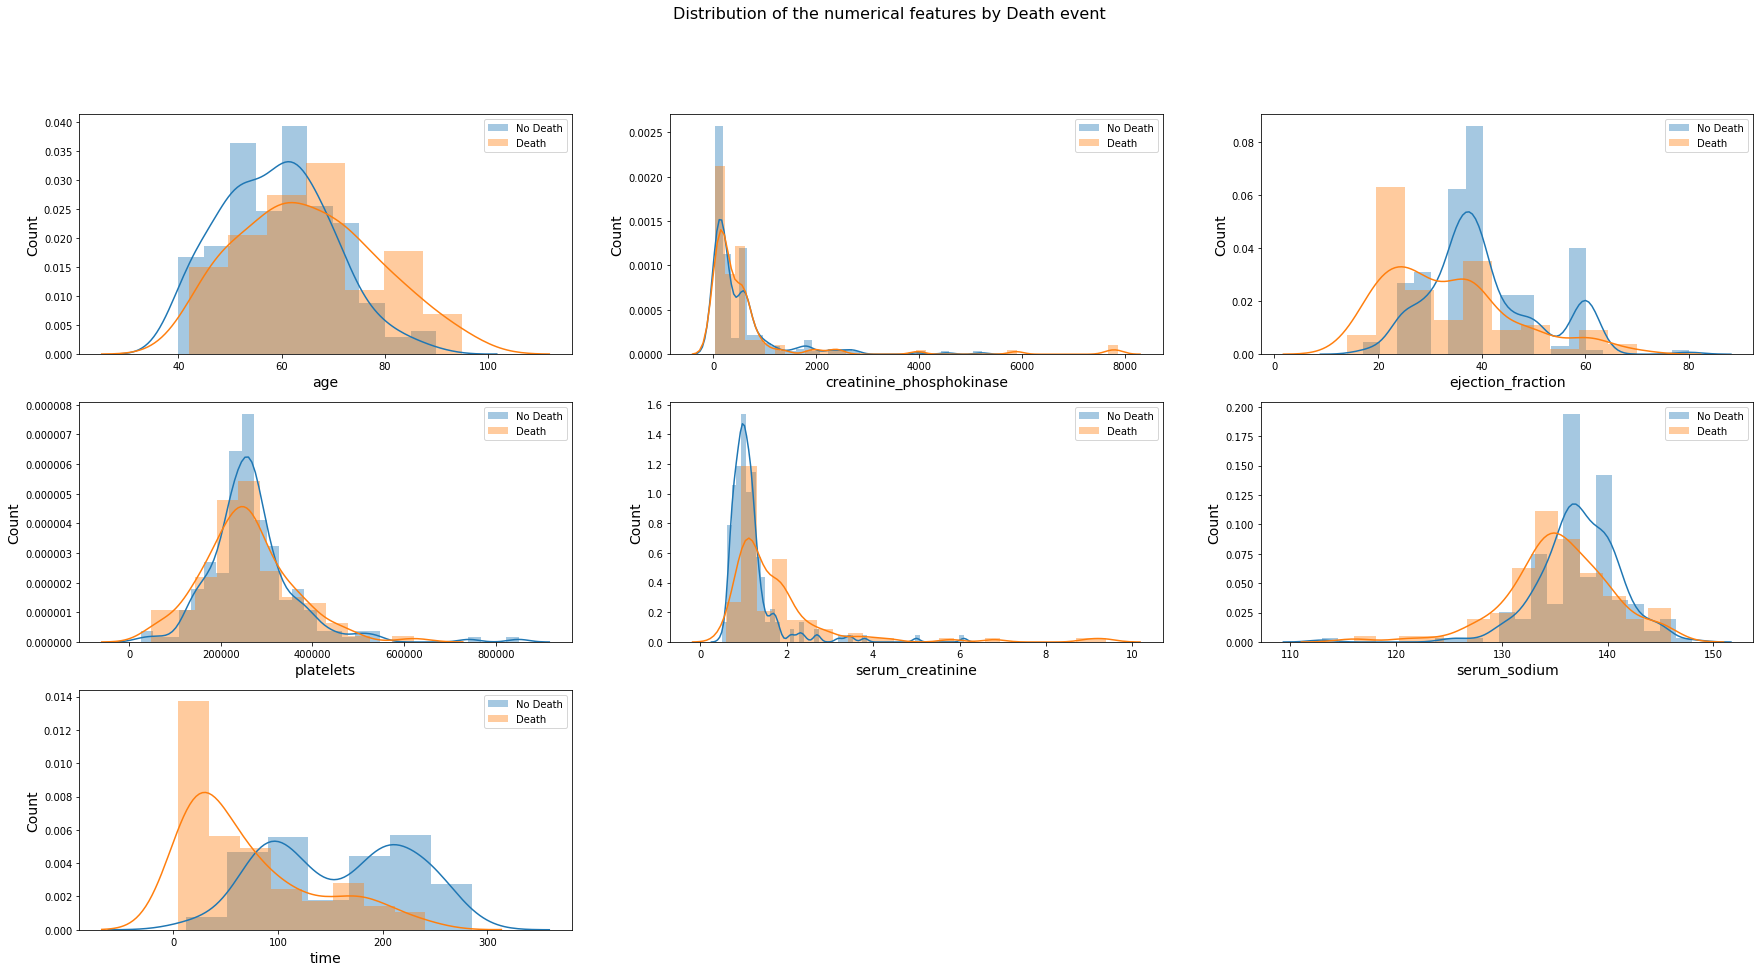

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))

for i, column in enumerate(numerical_columns):
    i0=i//3
    i1=i%3
    #axes[i0][i1].hist(clinicalData_0[column], bins=20, alpha=0.5, label="No Death")
    sns.distplot(clinicalData_0[column],ax=axes[i0][i1],label='No Death')
    #axes[i0][i1].hist(clinicalData_1[column], bins=20, alpha=0.5, label="Death")
    sns.distplot(clinicalData_1[column],ax=axes[i0][i1],label='Death')
    axes[i0][i1].set_xlabel(column, size=14)
    axes[i0][i1].set_ylabel("Count", size=14)
    axes[i0][i1].legend(loc='upper right')

fig.delaxes(axes[2,1])    
fig.delaxes(axes[2,2])
fig.suptitle('Distribution of the numerical features by Death event', fontsize=16)
plt.show()

**Age:** The two density graphs intersect at 70 years old. Before that point, the survivor's density plot is higher, and after that point, the deceased density plot is the one on top. This indicates that before the age of 70, the survival chances of our patients are higher.<br>

**Creatinine phosphokinase:** The density plots of the two groups don't show a lot of dissimilarities, which may be due to the scale of values going from a mode 582.0mcg/l to a maximum value of 7861.0mcg/l. <br>

**Ejection fraction:** Based on the density plots, the risks of death are higher before the ejection fraction of 30%. After this value, the survivor plot gets above the deceased one, which may indicate that survival chances are higher, but still, we can see that even though the Ejection fraction gets bigger there are some cases where the patients pass away.<br>

**Platelets:** The two density plots are similar to each other which coincides with our boxplot findings.<br>

**Serum creatinine:** We can see that density of surviving patients is very high compared to the deceased ones at low values of Serum creatinine approximately before 1.1mg/dL. Then from that point to neighboring 3.5mg/dL the density of dead people is higher, which may imply that high values of Serum creatinine increases the risk of death among heart failure patients.<br>

**Serum sodium:** We detect a range where the survival rates get higher for patients from approximately 135 to 145 mEq/L.<br>

**Time:** The death risk is higher with short follow-up periods, which led us to question the bias of this feature. If the follow-up was recorded after the death of the patient then this feature should not be considered, unfortunately, I was not able to find the procedure followed to collect this specific variable, in the following we will omit this feature to avoid any biased results.<br>

#### Categorical Features: 

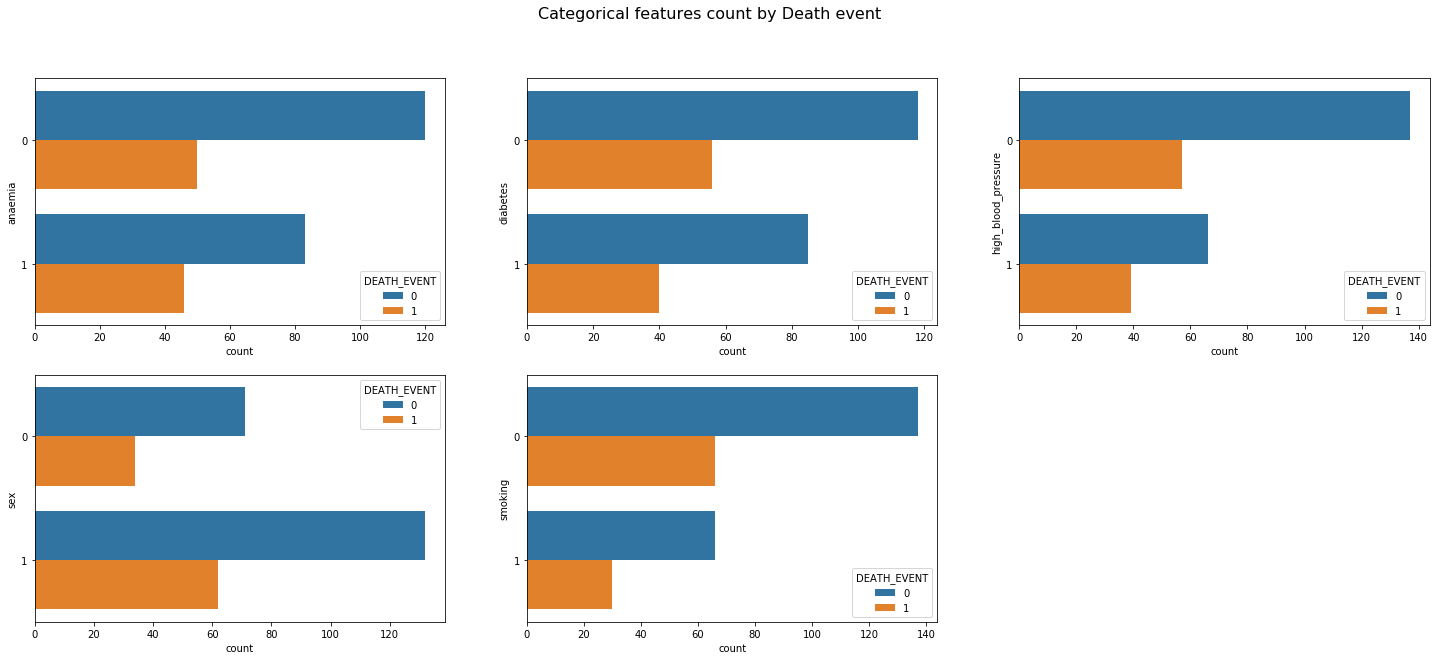

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for i,column in enumerate(categorical_columns):
    i0=i//3
    i1=i%3
    sns.countplot(data=clinicalData,y=column,hue='DEATH_EVENT',ax=axes[i0,i1])
    

fig.delaxes(axes[1,2])
fig.suptitle('Categorical features count by Death event', fontsize=16)
plt.show()

**Anaemia:** 
- Patients not suffering from anemia: 120 survived, and 50 died, which gives us a proportion of 70.6% survivors. 
- Patients suffering from anemia: 83 survived, and 46 died, which gives us a proportion of 64.34% survivors.

**Diabetes:** 
- Non Diabetic Patients: 118 survived, and 56 died, which gives us a proportion of 67.82% survivors. 
- Diabetic Patients: 85 survived, and 40 died, which gives us a proportion of 68% survivors.

**High Blood Pressure:** 
- Patients not suffering from high blood pressure: 137 survived, and 57 died, which gives us a proportion of 29.38% deceased. 
- Patients suffering from high blood pressure: 66 survived, and 39 died, which gives us a proportion of deceased equal to 37.14%.

**Sex:** 
- Women: 71 survived, and 34 died, which gives us a proportion of 67.62% of the women survived.
- Men: 132 survived, and 62 died, which gives us a proportion of survivors equal to 68.04%.

**Smoking:** 
- Nonsmokers: 137 survived and 66 died, which gives us a proportion of 32.51% deceased. 
- Smokers: 66 survived and 30 died, which gives us a proportion of 31.25% deceased. 

### Multivariate Analysis

In this section, we will draw the **Correlation Matrix**, which computes the **Pearson Correlation coefficient** between the variables. This analysis will allow us to identify the predictors that most impact our target variable (i.e DEATH_EVENT), and select a few features. The matrix also enables us to detect the most correlated features, which will allow us to pick noncorrelated features.

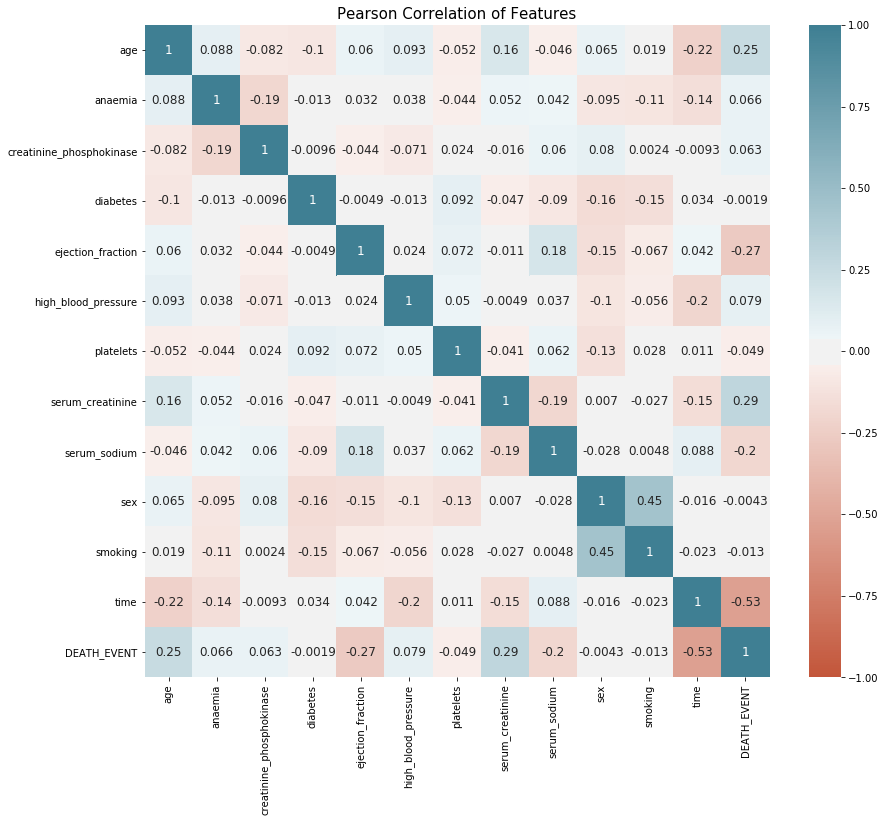

In [20]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', size = 15)
sns.heatmap(clinicalData.corr(),
            vmin=-1, vmax=1,
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            annot = True,
            annot_kws={'fontsize':12 })
plt.show()

**Target variable:** <br>
The correlation coefficients between the target variable and the predictors go from -0.53 to 0.29, and in absolute value from 0.0019 to 0.53. The features that have the highest correlation to the *DEATH_EVENT* (sorted in absolute value) are *Time* with a coefficient equal to -0.53, followed by *Serum Creatinine* which is positively correlated to the target with a coefficient of 0.29. Then *Ejection fraction* negatively correlated to *DEATH_EVENT* with a coefficient equal to -0.27, followed by age with a coefficient of 0.25, then *Serum Sodium* with a coefficient of 0.2, after this features the correlation coefficient drops to reach 0.079 for *High blood pressure*. Based on the found correlation coefficients we can test our classification models first on the features with a coefficient equal or greater than 0.2, then test the model with the other features.<br>

In [21]:
most_correlated = ['serum_creatinine','ejection_fraction','age','serum_sodium']

**Predictors:** <br>
From the analysis of the numerical features done earlier, we were expecting a high correlation between the *Creatinine phosphokinase* and *Serum creatinine* but the found coefficient -0.016 shows otherwise, this may be due to the high values of the outliers that increase the standard deviation of the *Creatinine phosphokinase* to 970.287881 which can lower the coefficient considerably, a solution to this might be to omit the outliers but since we have a small dataset I don't think that it is wise to do it.<br>
The most correlated two features are *Sex* and *Smoking* with a coefficient equal to 0.45.

## Test Classification Models

In this section, our objective is to find the best-fitted classification algorithm and the most impactful features.<br>
We will build different classification models, using the algorithms: **K-Nearest Neighbors, Logistic Regression, Naive Bayes, Support Vectors Machine, Decision Tree, and Random Forest**. For each algorithm, we will use all the features, then only the most correlated features to the target variable. We will compare the built models using the metrics: **accuracy, precision, recall, F1 score, and AUC ROC.**<br> 
- Accuracy: The proportion of true results among the total number of predictions.<br>
- Precision: The proportion of true positives among all the predicted positives.When we want to minimize the false positives.<br>
- Recall: The proportion of true positives among all actual positives ie the sum of True positives and False Negative.<br>
- F1-Score: Harmonic mean of Precision and Recall.<br>
- AUC-ROC: Indicates how well the Positive cases are separated from the negative ones.<br>

We will start by preprocessing the data and splitting it into training and test sets, then we will use cross-validation with 5 folds on the training set.

#### Data Preprocessing

First, we will omit the time column, and separate the remaining columns into a target variable **y** and predictors **X**.

In [22]:
clinicalData[most_correlated]

,serum_creatinine,ejection_fraction,age,serum_sodium
0,1.9,20,75.0,130
1,1.1,38,55.0,136
2,1.3,20,65.0,129
3,1.9,20,50.0,137
4,2.7,20,65.0,116
...,...,...,...,...
294,1.1,38,62.0,143
295,1.2,38,55.0,139
296,0.8,60,45.0,138
297,1.4,38,45.0,140


In [23]:
X = clinicalData.iloc[:,:-2]             #Omit the last 2 columns (time , Death_Event) the result will a pandas.dataframe
y = clinicalData.iloc[:,-1]              #Retrieve the last column (Death_Event) the result will a pandas.series
#Show the first 5 lines of X
X.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0


We separate our dataset into a training and test sets.

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=0)
#Show the first 5 lines of X_train
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
134,81.0,0,4540,0,35,0,231000.0,1.18,137,1,1
145,50.0,0,185,0,30,0,266000.0,0.70,141,1,1
63,45.0,0,582,0,35,0,385000.0,1.00,145,1,0
292,52.0,0,190,1,38,0,382000.0,1.00,140,1,1
284,50.0,1,54,0,40,0,279000.0,0.80,141,1,0


We will be testing several classification algorithms some use distance, some gradient descent, and some are tree-based. Although the latter does not require feature scaling, its accuracy stays the same whether we scale our features or not, so we will be scaling our numerical features for all the algorithms.
In this step, we will use standardization. I have chosen standardization because our dataset contains outliers, and standardization doesn't affect them.

In [25]:
# copy of datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

for column in numerical_columns[:-1]:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[column]])
    
    # transform the training data column
    X_train_stand[column] = scale.transform(X_train_stand[[column]])
    
    # transform the testing data column
    X_test_stand[column] = scale.transform(X_test_stand[[column]])

We will retrieve the most correlated columns from the standardized dataframes.

In [26]:
X_train_cor = X_train_stand[most_correlated]    #Retrieve the columns = most_correlated the result will a pandas.dataframe
X_test_cor = X_test_stand[most_correlated]    #Retrieve the columns = most_correlated the result will a pandas.dataframe

We will create a dataframe to store the metrics for all the models.

In [27]:
column_names = ['Algorithm','Accuracy','Precision','Recall','F1_Score','ROC_AUC']
metrics = pd.DataFrame(columns = column_names)

### K-Nearest Neighbors

K-Nearest Neighbors is a distance-based classification algorithm, where we predict the class of an observation based on the popular vote of its neighbors. In our case, we will use 4 neighbors and the euclidean distance which is the default distance in the **sklearn's KNeighborsClassifier.**

#### All columns

In [28]:
#create a new KNN model with 4 neighbors
knn = KNeighborsClassifier(n_neighbors=4)

#train model  
cv_scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(knn, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(knn, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(knn, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(knn, X_train_stand, y_train, cv=5, scoring='roc_auc')


metrics=metrics.append(pd.Series(['K-Nearest Neighbors (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)


#### Most Correlated columns

In [29]:
#create a new KNN model with 4 neighbors
knn = KNeighborsClassifier(n_neighbors=4)

#train model  
cv_scores = cross_val_score(knn, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(knn, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(knn, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(knn, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(knn, X_train_cor, y_train, cv=5, scoring='roc_auc')


metrics=metrics.append(pd.Series(['K-Nearest Neighbors (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)


### Logistic Regression

Logistic regression is a binary classification algorithm that uses the logistic function to predicts the probability of an observation belonging to a class.

#### All columns

In [30]:
#create a new logistic regression model 
LR = LogisticRegression()
#train model  
cv_scores = cross_val_score(LR, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(LR, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(LR, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(LR, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(LR, X_train_stand, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Logistic Regression (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

#### Most Correlated columns

In [31]:
#create a new logistic regression model 
LR = LogisticRegression()
#train model  
cv_scores = cross_val_score(LR, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(LR, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(LR, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(LR, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(LR, X_train_cor, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Logistic Regression (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

### Naive Bayes

Naive Bayes refers to a family of algorithms based on the Bayes Theorem.It is a conditional probability model where the class of an instance is the one with the higher conditional probality *P(y/X)*. In our case, we have chosen the Gaussian Naive Bayes because it's the most appropriate for datasets with Continuous Normal features. 

#### All columns

In [32]:
#create a new Naive Bayes model 
NB = GaussianNB()

#train model  
cv_scores = cross_val_score(NB, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(NB, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(NB, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(NB, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(NB, X_train_stand, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Naive Bayes (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

#### Most Correlated columns

In [33]:
#create a new Naive Bayes model 
NB = GaussianNB()

#train model  
cv_scores = cross_val_score(NB, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(NB, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(NB, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(NB, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(NB, X_train_cor, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Naive Bayes (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

### Support Vectors Machine

SVM is one of the most common classification algorithms. It aims to separate the classes with a hyperplane that maximizes the margin, or the distance between two classes.

#### All columns

In [34]:
#create a new SVM model 
svc = SVC()

#train model  
cv_scores = cross_val_score(svc, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(svc, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(svc, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(svc, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(svc, X_train_stand, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Support Vectors Machine (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

#### Most Correlated columns

In [35]:
#create a new SVM model 
svc = SVC()

#train model  
cv_scores = cross_val_score(svc, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(svc, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(svc, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(svc, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(svc, X_train_cor, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Support Vectors Machine (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

### Decision Tree

The name of this classification algorithm is revealing. Decision Tree Classifier is a classification algorithm that uses a decision tree-like structure where the leaves represent the classes and the branches the features associations leading to that class.

#### All columns

In [36]:
#create a new tree model 
tree = DecisionTreeClassifier()

#train model  
cv_scores = cross_val_score(tree, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(tree, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(tree, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(tree, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(tree, X_train_stand, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Decision Tree (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

#### Most Correlated columns

In [37]:
#create a new tree model 
tree = DecisionTreeClassifier()

#train model  
cv_scores = cross_val_score(tree, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(tree, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(tree, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(tree, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(tree, X_train_cor, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Decision Tree (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

### Random Forest

Random Forest is an ensemble algorithm the class is predicted using the popular vote of the forest i.e the decision trees, in our case, we will use a 1000 estimator.

#### All columns

In [38]:
#create a new Random Forest model 
RF = RandomForestClassifier(n_estimators=1000)

#train model  
cv_scores = cross_val_score(RF, X_train_stand, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(RF, X_train_stand, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(RF, X_train_stand, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(RF, X_train_stand, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(RF, X_train_stand, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Random Forest (All columns)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

#### Most Correlated columns

In [39]:
#create a new Random Forest model 
RF = RandomForestClassifier(n_estimators=1000)

#train model  
cv_scores = cross_val_score(RF, X_train_cor, y_train, cv=5)
#train model using precision
cv_scores_precision = cross_val_score(RF, X_train_cor, y_train, cv=5, scoring='precision')
#train model using Recall
cv_scores_recall = cross_val_score(RF, X_train_cor, y_train, cv=5, scoring='recall')
#train model using f1 score
cv_scores_f1 = cross_val_score(RF, X_train_cor, y_train, cv=5, scoring='f1')
#train model using roc_auc
cv_scores_roc_auc = cross_val_score(RF, X_train_cor, y_train, cv=5, scoring='roc_auc')

metrics=metrics.append(pd.Series(['Random Forest (Most Correlated)',np.mean(cv_scores),np.mean(cv_scores_precision),np.mean(cv_scores_recall),np.mean(cv_scores_f1),np.mean(cv_scores_roc_auc)],
                         index=metrics.columns),
               ignore_index=True)

### Resulting Metrics

Let's find out the resulting metrics for all the models. We should note that the metrics are the average of the folds used in the 5-folds cross-validation.

In [40]:
metrics

,Algorithm,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,K-Nearest Neighbors (All columns),0.719681,0.633333,0.180000,0.278638,0.694132
1,K-Nearest Neighbors (Most Correlated),0.723670,0.560952,0.258095,0.344863,0.761336
2,Logistic Regression (All columns),0.761613,0.712727,0.421905,0.514991,0.791049
3,Logistic Regression (Most Correlated),0.765869,0.720855,0.421905,0.521609,0.776847
4,Naive Bayes (All columns),0.711525,0.561905,0.260952,0.355280,0.760678
5,Naive Bayes (Most Correlated),0.749202,0.669762,0.327619,0.433877,0.779473
6,Support Vectors Machine (All columns),0.732181,0.676869,0.353333,0.421704,0.792465
7,Support Vectors Machine (Most Correlated),0.740514,0.592108,0.433333,0.489241,0.781976
8,Decision Tree (All columns),0.699025,0.596263,0.480952,0.594331,0.647825
9,Decision Tree (Most Correlated),0.744770,0.554444,0.562857,0.501437,0.687031


In both Accuracy and Precision, we find that Logistic Regression using the Most Correlated features has the highest scores: 0.765869 and 0.720855 respectively. Which imply that Logistic Regression allows us the most to be sure about our positive prediction, 72% of the predicted deaths are actual death.<br>
On the other hand, The model Random Forest using the Most Correlated features has the highest Recall scores with the value 0.573333, and F1 Score with the value 594853. It means that this algorithm permits capturing as many positive cases as possible, which we understand from the Recall. But it also has the highest F1 Score, which indicates that it has good precision also.<br>
The AUC ROC is the only metric where a model that uses all columns has the highest score, which is the Random Forest with the value 0.820651. It means it has the highest measure of separability. It separates the deceased patient from the surviving ones. It is closely followed by the Random Forest with Most Correlated Features, as it has a score of 0.820507.<br>
Giving our problem and the resulting metrics the Random Forest with Most Correlated Features seems to be the most suited as it permits us to predict as many deaths as possible.<br>
In the following, we will validate our results by training the algorithms on the training set and predict for the test set.

### Training the models

In [41]:
#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train_stand,y_train)
knn1 = KNeighborsClassifier(n_neighbors=4)
knn1.fit(X_train_cor,y_train)

#Logistic Regression
LR = LogisticRegression()
LR.fit(X_train_stand,y_train)
LR1 = LogisticRegression()
LR1.fit(X_train_cor,y_train)

#Naive Bayes 
NB = GaussianNB()
NB.fit(X_train_stand,y_train)
NB1 = GaussianNB()
NB1.fit(X_train_cor,y_train)

#Support Vectors Machine 
svc = SVC()
svc.fit(X_train_stand,y_train)
svc1 = SVC()
svc1.fit(X_train_cor,y_train)

#Decision Tree 
tree = DecisionTreeClassifier()
tree.fit(X_train_stand,y_train)
tree1 = DecisionTreeClassifier()
tree1.fit(X_train_cor,y_train)

#Random Forest 
RF = RandomForestClassifier(n_estimators=1000)
RF.fit(X_train_stand,y_train)
RF1 = RandomForestClassifier(n_estimators=1000)
RF1.fit(X_train_cor,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Predicting the classes

In [42]:
#K-Nearest Neighbors
y_knn = knn.predict(X_test_stand)
y_knn1= knn1.predict(X_test_cor)

#Logistic Regression
y_LR = LR.predict(X_test_stand)
y_LR1 = LR1.predict(X_test_cor)

#Naive Bayes 
y_NB = NB.predict(X_test_stand)
y_NB1 = NB1.predict(X_test_cor)

#Support Vectors Machine 
y_svc = svc.predict(X_test_stand)
y_svc1 = svc1.predict(X_test_cor)

#Decision Tree 
y_tree = tree.predict(X_test_stand)
y_tree1 = tree1.predict(X_test_cor)

#Random Forest 
y_RF = RF.predict(X_test_stand)
y_RF1 = RF1.predict(X_test_cor)

### Evaluating the metrics

In [43]:
column_names = ['Algorithm','Accuracy','Precision','Recall','F1_Score','ROC_AUC']
metrics_evaluation = pd.DataFrame(columns = column_names)
algorithms=['K-Nearest Neighbors (All columns)','K-Nearest Neighbors (Most Correlated)','Logistic Regression (All columns)','Logistic Regression (Most Correlated)',
            'Naive Bayes (All columns)','Naive Bayes (Most Correlated)','Support Vectors Machine (All columns)','Support Vectors Machine (Most Correlated)',
            'Decision Tree (All columns)','Decision Tree (Most Correlated)','Random Forest (All columns)','Random Forest (Most Correlated)']
y_preds = [y_knn,y_knn1,y_LR,y_LR1,y_NB,y_NB1,y_svc,y_svc1,y_tree,y_tree1,y_RF,y_RF1]

for (algo, y_pred) in zip(algorithms, y_preds): 
    metrics_evaluation=metrics_evaluation.append(pd.Series([algo,
                                                            accuracy_score(y_test,y_pred),
                                                            precision_score(y_test,y_pred),
                                                            recall_score(y_test,y_pred),
                                                            f1_score(y_test,y_pred),
                                                            roc_auc_score(y_test,y_pred)],
                             index=metrics.columns),
                             ignore_index=True)
metrics_evaluation    

,Algorithm,Accuracy,Precision,Recall,F1_Score,ROC_AUC
0,K-Nearest Neighbors (All columns),0.650000,0.625000,0.217391,0.322581,0.568155
1,K-Nearest Neighbors (Most Correlated),0.616667,0.500000,0.173913,0.258065,0.532902
2,Logistic Regression (All columns),0.733333,0.818182,0.391304,0.529412,0.668625
3,Logistic Regression (Most Correlated),0.733333,0.769231,0.434783,0.555556,0.676851
4,Naive Bayes (All columns),0.650000,0.600000,0.260870,0.363636,0.576381
5,Naive Bayes (Most Correlated),0.716667,0.750000,0.391304,0.514286,0.655112
6,Support Vectors Machine (All columns),0.750000,0.750000,0.521739,0.615385,0.706816
7,Support Vectors Machine (Most Correlated),0.750000,0.750000,0.521739,0.615385,0.706816
8,Decision Tree (All columns),0.666667,0.600000,0.391304,0.473684,0.614571
9,Decision Tree (Most Correlated),0.616667,0.500000,0.347826,0.410256,0.565805


The results are completely different than our cross-validation results which may due to overfitting and the small size of our dataset. In the cross-validation step, the Random Forest model seemed the most suited for our need, but after the validation step, we see that SVM is doing the best across the majority of the metrics. It scored the highest accuracy with 0.75, the highest recall with 0.521739, the highest F1 Score with 0.61, and the highest AUC ROC with 0.7. We note also that the values are equal either we use all the features or only the most correlated to our target variable.
The precision of the Logistic is also very good, it reaches 0.81.
To summarize our results, if we are interested in predicting the most cases that can die, even if we falsely classify a surviving patient as a potentially deceased patient, then using SVM with features : ['serum_creatinine', 'ejection_fraction', 'age', 'serum_sodium'] is the way to go. If, on the other hand, we are interested in predicting with the most certainty which patient will die, which means avoiding flagging a surviving patient as potentially deceased, then we should choose the Logistic Regression model with all the features.<br>
Let's check the confusion matrices of the different models to a better grasp of their respective performances.

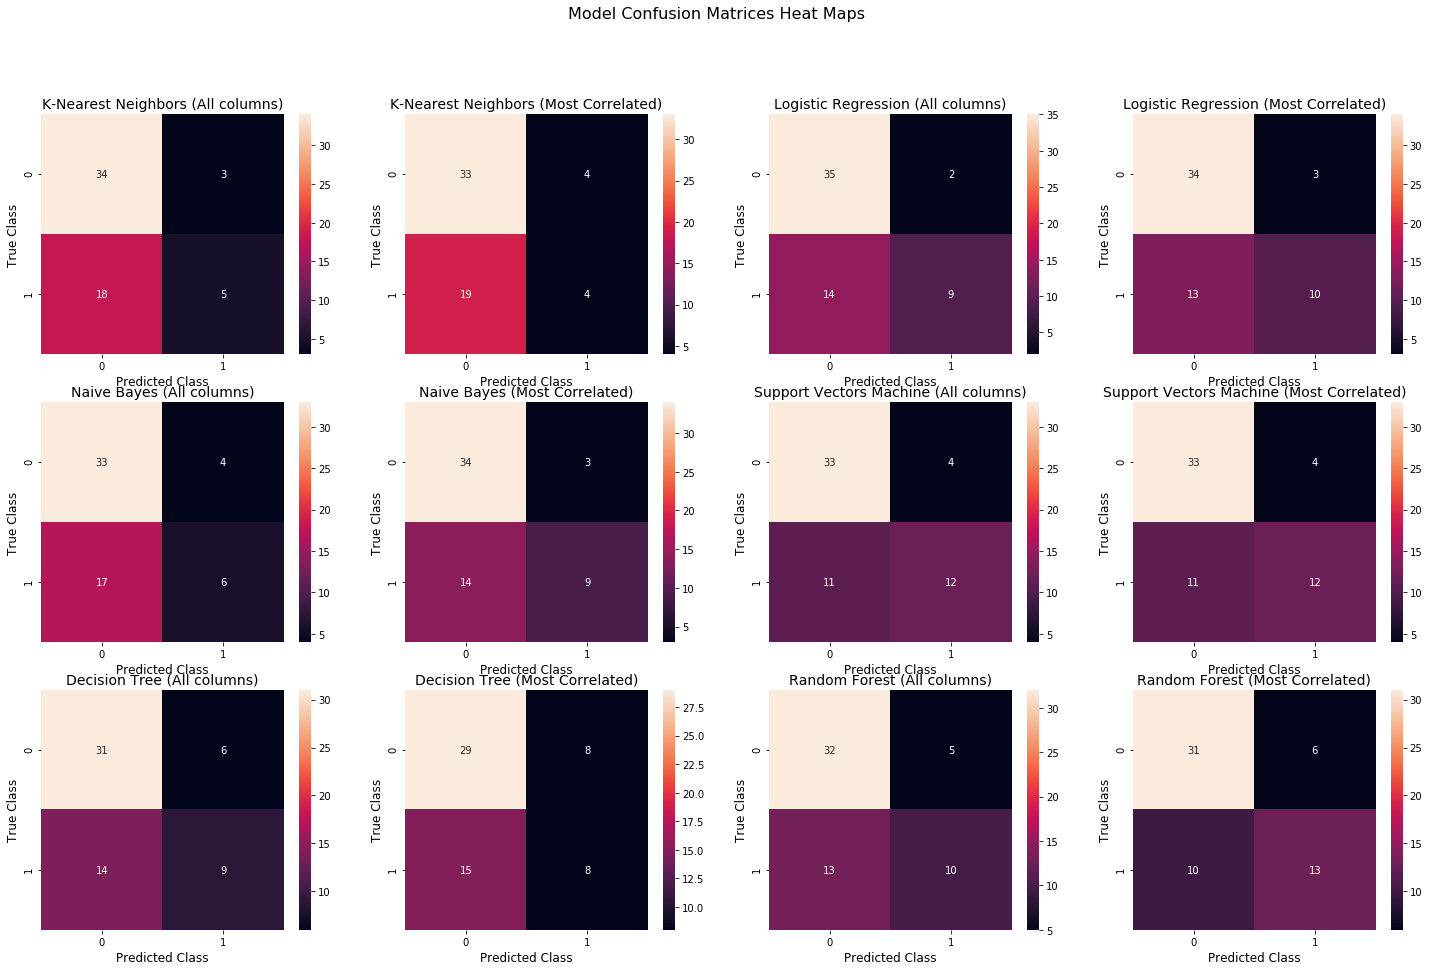

In [44]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15))

for (i,algo, y_pred) in zip(range(12),algorithms, y_preds): 
    i0=i//4
    i1=i%4
    cm = confusion_matrix(y_test,y_pred)
    sns.heatmap(cm, annot=True, ax=axes[i0,i1])
    axes[i0][i1].set_xlabel('Predicted Class', size=12)
    axes[i0][i1].set_ylabel('True Class', size=12)
    axes[i0][i1].set_title(algo, size=14)
fig.suptitle('Model Confusion Matrices Heat Maps', fontsize=16)
plt.show()

The confusion matrices confirm the found metrics. We can see that SVC or Support Vector Machine classifier is the model that minimizes the False Negatives with 11 deceased patients falsely label as surviving. The Logistic Regression using all the features minimizes the False Positive rate with only 2 surviving patients flagged as deceased.

## Conclusion

In this brief study, we found that **Support Vector Machine** was the most suited algorithm to find cardiovascular patients with a high risk of death and potentially save them. It also showed that the features: **Serum Creatinine, Ejection Fraction, Age, and Serum Sodium** have the most impact, among the features at hand, on death prediction and can be sufficient.<br>
The results we found can be improved by different techniques like :
- Feature engineering: By creating bins of  creatinine_phosphokinase and platelets to see their impact.
- Log Transformation: To transform our continuous features into a smother gaussian distribution which may result in a better Naive Bayes Performance.
This exercise allowed me to explore ways to analyze the data and to take a closer look into the different features and their distributions, before applying machine learning algorithm blindly. It was also an opportunity to familiarize myself with health related datasets and problems.

## Reference

[0]<a name='ref0' href='https://www.kaggle.com/andrewmvd/heart-failure-clinical-data'> https://www.kaggle.com/andrewmvd/heart-failure-clinical-data</a> *License : Attribution 4.0 International (CC BY 4.0)* <br>
[1]<a name='ref1' href='https://rdcu.be/ccbFM'>https://rdcu.be/ccbFM </a> <br>
[2]<a name='ref2' href='https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test'>https://www.mountsinai.org/health-library/tests/creatine-phosphokinase-test </a> <br>
[3]<a name='ref3' href='https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement'>https://www.heart.org/en/health-topics/heart-failure/diagnosing-heart-failure/ejection-fraction-heart-failure-measurement </a> <br>
[4]<a name='ref4' href='https://www.urmc.rochester.edu/encyclopedia/content.aspx?ContentTypeID=160&ContentID=36'>https://www.urmc.rochester.edu/encyclopedia/content.aspx?ContentTypeID=160&ContentID=36 </a><br>
[5]<a name='ref5' href='https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5'>https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5 </a> <br>
[6]<a name='ref6' href='https://www.healthline.com/health/sodium-blood'>https://www.healthline.com/health/sodium-blood </a> <br>
[7]<a name='ref7' href='https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/'>https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/ </a><br>